# Table of contents
* [Word Tokenization](#word-tokenization)
    * [Most Common Words](#most-common-words)
    * [Feature Creation](#most-common-words-feature-creation)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Import the tweets dataset, this is a cut down version of the full tweet 
# dataset per the operations performed in the file "eda-rea-v-liv-2018"
en_tweets_df = pd.read_csv('en_tweets_df.csv', lineterminator='\n')

In [3]:
# As this dataset is generated from earlier work it carries its prior index, the below changes the column name
en_tweets_df.rename(columns={'Unnamed: 0':'original_df_index'}, inplace=True)

In [2]:
# Import NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn import preprocessing

import re

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Word Tokenization <a class="anchor" id="word-tokenization"></a>

In [34]:
# Create a function that returns tokenizes, cleans and stems words for a tweet
english_stopwords = stopwords.words('english')

# Context specific stop words (refer "most common words" section below for identification approach
# rt = short for retweet, this does not provide any insights and a column already exists to identify retweets
# http & https = the start of web links these provide little value as "words", future work: these could be
# to build a feature along thelines of "Contains Web Link?"
# uclfinal, championsleague, championsleaguefinal = "hashtag"/topical words, given the original tweet dataset
# contained only tweets that had a hashtag of uclfinal these words do not add value to the analysis
custom_stopwords = ['rt', 'http', 'https', 'uclfinal', 'championsleague', 'championsleaguefinal', 'lfcrma',  
                    'liverpoolvsrealmadrid', 'livrma', 'realiv', 'realliverpool', 'realmadridliverpool', 'realmadridvsliverpool', 
                    'rmalfc', 'rmaliv', 'rmavlfc', 'rmavliv', 'rmavsliv', 'rmliv', 'rmvsliv', 'retweet', 'retweeted']

ps = PorterStemmer()

# Combine the two stop words lists
stop_words = english_stopwords + custom_stopwords

def TokenizeTweet(tweet):
    word_tokenized = word_tokenize(tweet)

    
    cleaned_words_tokenized = [word.lower().strip() for word in word_tokenized] # lowercasing
    
    cleaned_words_tokenized = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', word) for word in cleaned_words_tokenized] # remove URLs
    cleaned_words_tokenized = [re.sub('@[^\s]+', 'AT_USER', word) for word in cleaned_words_tokenized] # remove usernames
    cleaned_words_tokenized = [re.sub(r'#([^\s]+)', r'\1', word) for word in cleaned_words_tokenized] # remove the # in #hashtag   
    cleaned_words_tokenized = [word.replace('(','').replace(')','') for word in cleaned_words_tokenized if word.isalpha()]  # replacing some unwanted things
    
    # Ideally all checks could be moved into this single for loop, rather than iterating words multiple times.
    for n, i in enumerate(cleaned_words_tokenized):
        if i in ['liverpool', 'lfc', 'ufcliverpool', 'liv']:
            cleaned_words_tokenized[n] = 'liverpoolfc'
            
        if i in ['rma', 'madrid']:
            cleaned_words_tokenized[n] = 'realmadrid'
    
    cleaned_words_tokenized = [word for word in cleaned_words_tokenized if word not in stop_words] # removing stopwords
    cleaned_words_tokenized = [ps.stem(word) for word in cleaned_words_tokenized] # stemming
    
    return cleaned_words_tokenized

In [35]:
# Tokenize words in tweets
en_tweets_df['tokenized_words'] = en_tweets_df.apply(lambda row: TokenizeTweet(row['tweet_text']), axis=1)

### Most Common Words <a class="anchor" id="most-common-words"></a>

In [43]:
# There are three key benefits to finding the most common words:
    # 1. Further refinements could be made to TokenizedWords in terms of words to exclude
    # 2. We can obtain further insights into the data
    # 3. Can select key words that could be used to generate features    

# Convert tokenized words column into a single list of words
words_list = en_tweets_df['tokenized_words'].values.tolist()

# Flatten the list
flattened_words_list = [j for sub in words_list for j in sub]

# Find the most common words
fdist = FreqDist(x.lower() for x in flattened_words_list)
fdist.most_common(25)

[('liverpoolfc', 48196),
 ('salah', 37548),
 ('ramo', 31736),
 ('realmadrid', 28476),
 ('bale', 22325),
 ('goal', 21128),
 ('real', 20624),
 ('sergio', 14425),
 ('gareth', 11275),
 ('final', 10888),
 ('world', 8579),
 ('mo', 8537),
 ('kariu', 8418),
 ('one', 7910),
 ('ronaldo', 7447),
 ('cup', 7347),
 ('time', 7302),
 ('shoulder', 7209),
 ('game', 7119),
 ('like', 7022),
 ('win', 6609),
 ('score', 6590),
 ('ever', 6378),
 ('watch', 6345),
 ('come', 6275)]

### TF-IDF Feature Creation  <a class="anchor" id="most-common-words-feature-creation"></a>

In [7]:
en_tweets_df_text_only = en_tweets_df[['id','tweet_text', 'tokenized_words']]
en_tweets_df_text_only.sample(5)

,id,tweet_text,tokenized_words
48270,1.000457e+18,"And now it's Carvajal, 😢😢\nWhy God why... #UCL...","[carvaj, god]"
180434,1.000477e+18,RT @ChampionsLeague: ⏰FULL TIME! ⏰\nReal Madri...,"[time, real, realmadrid, make, three, ucl, tit..."
86128,1.000463e+18,@AlexiLalas are ya sure? https://t.co/MVOR23rwiv,"[alexilala, ya, sure]"
175903,1.000476e+18,RT @iAmAClipse: Here for this... https://t.co/...,[iamaclips]
80848,1.000462e+18,@SimpsonsQOTD Posted... \nhttps://t.co/vsrKt1PSmp,"[simpsonsqotd, post]"


In [ ]:
en_tweets_df['flatten_tokenized_words'] = en_tweets_df.apply(lambda row: ' '.join(row['tokenized_words']), axis=1)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(en_tweets_df['flatten_tokenized_words'])

In [68]:
len(v.get_feature_names())

25654

### Models <a class="anchor" id="most-common-words-models"></a>

#### KMeans <a class="anchor" id="most-common-words-kmeans"></a>

In [58]:
import sklearn
import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA

NameError: name 'num_of_FT_cols' is not defined

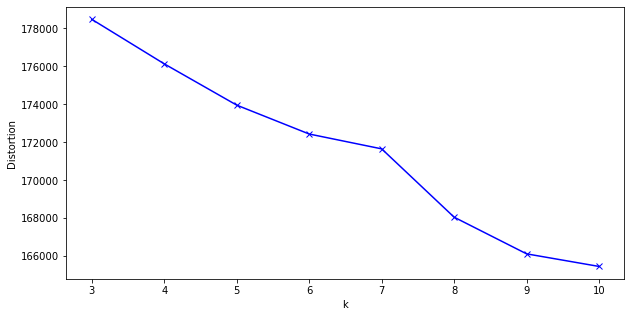

In [60]:
pd.options.mode.chained_assignment = None  # default='warn'

distortions = []

K = range(3, 11)
for k in K:
    X = x

    # Fit and predict model
    kmeans = KMeans(n_clusters=k, random_state=8)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
        
plt.figure(figsize=(10, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title(f'The Elbow Method showing the optimal k with')
plt.show()

In [74]:
X = x

# Fit and predict model
kmeans = KMeans(n_clusters=6, random_state=8)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)



In [75]:
# Print a number of tweets for each cluster
y = pd.Series(y_kmeans)
df_tweet_y = pd.DataFrame(en_tweets_df[en_tweets_df['is_retweet']==False])
df_tweet_y['y'] = pd.Series(y)

pd.set_option('display.max_colwidth', None)

print(f'------------------------------------------------------------------------')
print(f'------------------------------------------------------------------------')
# print(f'k = {k} ---- Number of FT cols = {num_of_FT_cols}')
print(f'Data shape = {X.shape}')

for i in range(0, 6):
    print(f'****************************************** \n Cluster {i}')
    print('******************************************')
    print(df_tweet_y['tweet_text'][(df_tweet_y['y'] == i)].sample(15).to_string())
    print('****************************************** \n')

print(f'------------------------------------------------------------------------')
print(f'------------------------------------------------------------------------\n\n\n')

------------------------------------------------------------------------
------------------------------------------------------------------------
Data shape = (188087, 25654)
****************************************** 
 Cluster 0
******************************************
36532                                                                                                         #UCLfinal #ramos did that deliberately #cheat
74263                                           Sergio Ramos belongs in the octagon. #ChampionsLeague #UCLFinal #ريال_مدريد_ليفربول https://t.co/lVWfNkcR5G
35223                                                                                                                          Ramos back on duty #UCLfinal
105569                                        What I wouldn't give for 30 minutes with Sergio Ramos...#UCLfinal    \n\nWait....that's not what I meant.....
70389                            Sergio Ramos is a captain that would do anything for his team to win. 

In [65]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
reduced_data = PCA(n_components=2).fit_transform(X)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

plt.figure(figsize=(40,30))
sns.scatterplot(x="pca1", y="pca2", hue=y_kmeans, data=results)
plt.title('K-means Clustering')
plt.show()

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [ ]:
# # Identify the optimal number of clusters (k), also considering the number of feature columns. This should assist in review of the cluster samples output.
# pd.options.mode.chained_assignment = None  # default='warn'
# K = range(3, 11)
# for num_of_FT_cols in range(25, 251, 25):
#     distortions = []
#     for k in K:
#         # Create X ensuring only records that have at least one of the features are included
#         X = en_tweets_df_with_features[cols[:num_of_FT_cols]]
#         X['sum_of_FT_cols'] = X.sum(axis=1)
#         X = X[cols[:num_of_FT_cols]][X['sum_of_FT_cols'] != 0]

#         X_scaled = preprocessing.scale(X)

#         # Fit and predict model
#         kmeans = KMeans(n_clusters=k, random_state=8)
#         kmeans.fit(X_scaled)
#         distortions.append(kmeans.inertia_)
        
#     plt.figure(figsize=(10, 5))
#     plt.plot(K, distortions, 'bx-')
#     plt.xlabel('k')
#     plt.ylabel('Distortion')
#     plt.title(f'The Elbow Method showing the optimal k with {num_of_FT_cols} feature columns')
#     plt.show()

In [50]:
# Based on the above diagrams 7 clusters with 225 looks like it could hold some insights
# Create X ensuring only records that have at least one of the features are included
# k = 6
# X = en_tweets_df[cols]
# # X['sum_of_FT_cols'] = X.sum(axis=1)
# # X = X[cols][X['sum_of_FT_cols'] != 0]

# # Fit and predict model
# kmeans = KMeans(n_clusters=k, random_state=8)
# kmeans.fit(X)
# y_kmeans = kmeans.predict(X)

In [53]:
# Print a number of tweets for each cluster
y = pd.Series(y_kmeans)
df_tweet_y = pd.DataFrame(en_tweets_df)
df_tweet_y['y'] = pd.Series(y)

pd.set_option('display.max_colwidth', None)

print(f'------------------------------------------------------------------------')
print(f'------------------------------------------------------------------------')
# print(f'k = {k} ---- Number of FT cols = {num_of_FT_cols}')
print(f'Data shape = {X.shape}')

for i in range(0, k):
    print(f'****************************************** \n Cluster {i}')
    print('******************************************')
    print(df_tweet_y['tweet_text'][(df_tweet_y['y'] == i)].sample(15).to_string())
    print('****************************************** \n')

print(f'------------------------------------------------------------------------')
print(f'------------------------------------------------------------------------\n\n\n')

------------------------------------------------------------------------
------------------------------------------------------------------------
Data shape = (188087, 772)
****************************************** 
 Cluster 0
******************************************
156428                          RT @itsnotJesusXO: Fuck football. Fuck this game. Fuck Real Madrid. Fuck their referees. Fuck UEFA. https://t.co/naqHnqpS7U
82900         RT @TOKOYVMI: FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS\nFUCK RAMOS FUCK…
54364         RT @TOKOYVMI: FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS\nFUCK RAMOS FUCK…
73296         RT @Samuel14122417: FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS FUCK RAMOS\nFUCK RAMO…
52887     RT @JrMoe_: FUCK YOU, SERGIO RAMOS\nFUCK YOU, SERGIO RAMOS\nFUCK YOU, SERGIO RAMOS\nFUCK YOU, S

In [ ]:
# Return 3 - 10 clusters for cummulative sets of 25 columns, the first 25 are the most common words
for k in range(3, 11):
    for num_of_FT_cols in range(25, 501, 25):
        # Create X ensuring only records that have at least one of the features are included
        X = en_tweets_df_with_features[cols[:num_of_FT_cols]]
        X['sum_of_FT_cols'] = X.sum(axis=1)
        X = X[cols[:num_of_FT_cols]][X['sum_of_FT_cols'] != 0]

        # Fit and predict model
        kmeans = KMeans(n_clusters=k, random_state=8)
        kmeans.fit(X)
        y_kmeans = kmeans.predict(X)
        
        # Print a number of tweets for each cluster
        y = pd.Series(y_kmeans)
        df_tweet_y = pd.DataFrame(en_tweets_df_with_features)
        df_tweet_y['y'] = pd.Series(y)

        pd.set_option('display.max_colwidth', None)
        
        print(f'------------------------------------------------------------------------')
        print(f'------------------------------------------------------------------------')
        print(f'k = {k} ---- Number of FT cols = {num_of_FT_cols}')
        print(f'Data shape = {X.shape}')

        for i in range(0, k):
            print(f'****************************************** \n Cluster {i}')
            print('******************************************')
            print(df_tweet_y['tweet_text'][(df_tweet_y['y'] == i) & (df_tweet_y['is_retweet'] == False)].sample(5).to_string())
            print('****************************************** \n')
            
        print(f'------------------------------------------------------------------------')
        print(f'------------------------------------------------------------------------\n\n\n')

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# Useful snippets etc.

In [ ]:
###############################################################
# Memory usage https://stackoverflow.com/questions/16261240/releasing-memory-of-huge-numpy-array-in-ipython/16278056
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))